# Favourite Animal Detection
## Assignment 2

### created by: Sanjaya Gunawardena

# About the Dataset:

Context

This data set was collected with the original goal of training an embedded device to perform real-time animal detection in nature reserves in South Africa.

This data set contains at least 376 images for each animal class collected via Google's image search function and labelled for object detection. Each example in the data set consists of a jpg image and a txt label file. The images have differing aspect ratios and contain at least one example of the specified animal class. Multiple instances of animals can exist in a single image. 

In this notebook I am using YOLO v8 and check the model performance

## Loading the required libraries

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
import cv2
import random

## Creating the folders and directories

In [3]:
# Creating paths for separate images and labels
curr_path=os.getcwd()
imgtrainpath = os.path.join(curr_path,'images','train')
imgvalpath=os.path.join(curr_path,'images','validation')
imgtestpath=os.path.join(curr_path,'images','test')

labeltrainpath=os.path.join(curr_path,'labels','train')
labelvalpath=os.path.join(curr_path,'labels','validation')
labeltestpath=os.path.join(curr_path,'labels','test')

# Creating directories for all paths defined
os.makedirs(imgtrainpath)
os.makedirs(imgvalpath)
os.makedirs(imgtestpath)
os.makedirs(labeltrainpath)
os.makedirs(labelvalpath)
os.makedirs(labeltestpath)

In [4]:
BASE_PATH = '/kaggle/input/african-wildlife' 
IMAGE_SIZE = 640  #The desired image size for resizing is defined
for dirname in os.listdir(BASE_PATH):
    dirpath=os.path.join(BASE_PATH, dirname)
    for file in os.listdir(dirpath):
        filepath=os.path.join(dirpath, file)
        newname=dirname+'_'+file
        if file.endswith((".txt")): 
            shutil.copy(filepath, labeltrainpath)
            path=os.path.join(labeltrainpath, file) #If the file is a label file, it is copied to the training label directory, and its path is updated.
            newpath=os.path.join(labeltrainpath, newname)
        elif file.endswith((".jpg", ".JPG")): 
            img_resized=cv2.resize(cv2.imread(filepath), (IMAGE_SIZE, IMAGE_SIZE))
            path=os.path.join(imgtrainpath, file)
            cv2.imwrite(path, img_resized)  #If the file is an image file, it is read, resized, and saved to the training image directory with the updated path
            newpath=os.path.join(imgtrainpath, newname)
        os.rename(path, newpath) 

In [5]:
# Checking the size of train dataset
len(os.listdir(imgtrainpath)), len(os.listdir(labeltrainpath))

(1504, 1504)

This indicates that:

Data Availability: We have a substantial number of training examples, which is generally good for training deep learning models.

Label-Image Correspondence: The number of images matches the number of labels, which is crucial for supervised learning tasks where each image should have a corresponding label.

In [6]:
for file in os.listdir(labeltrainpath):
    classes_set=set()
    with open(os.path.join(labeltrainpath, file), "r") as f:
        for line in f:
            class_id,_,_,_,_=line.strip().split(" ")
            classes_set.add(class_id)
    if len(classes_set) > 1:
        filepath=os.path.join(labeltrainpath, file)
        newpath=os.path.join(labeltestpath, file)
        shutil.move(filepath, newpath) # moving label file to test path
        basename=os.path.splitext(file)[0]
        print(basename) # printing the image name
        imgfilename=basename+'.jpg'
        oldimgfilepath=os.path.join(imgtrainpath, imgfilename)
        newimgfilepath=os.path.join(imgtestpath, imgfilename) 
        shutil.move(oldimgfilepath, newimgfilepath) # moving image to test path

zebra_073
rhino_375
elephant_288
elephant_291
buffalo_297
buffalo_273
elephant_166
zebra_339
rhino_256
buffalo_291
buffalo_299
elephant_290
rhino_238
zebra_338
buffalo_301
buffalo_300
buffalo_298
elephant_345


The script processes label files in the labeltrainpath directory to identify and move images and their corresponding labels containing multiple object classes to the labeltestpath directory. This is useful for separating complex images (with multiple objects) from simpler ones in the training dataset

In [7]:
# Checking the size of test dataset
len(os.listdir(imgtestpath)), len(os.listdir(labeltestpath))

(18, 18)

### Displaying a sample image

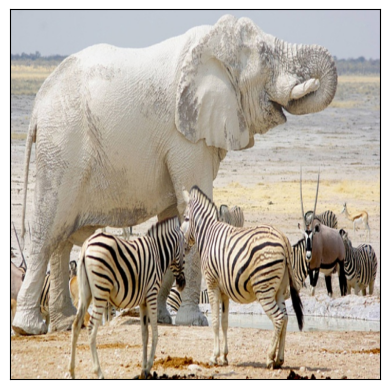

In [8]:
import os
import cv2
import matplotlib.pyplot as plt

image_path = '/kaggle/working/images/test/elephant_290.jpg'

# Check if the file exists
if os.path.exists(image_path):
    img = cv2.imread(image_path)
    
    # Check if img is None (indicating failure to read)
    if img is not None:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
        plt.xticks([])
        plt.yticks([])
        plt.show()
    else:
        print(f"Failed to read image at {image_path}")
else:
    print(f"File {image_path} not found")


### train/validation dataset split

In [9]:

factor=0.2  # Define the fraction of the dataset to be used for validation


# Randomly select a subset of images from the training dataset
# The number of selected images is determined by the 'factor' value
for file in random.sample(os.listdir(imgtrainpath), int(len(os.listdir(imgtrainpath))*factor)):
    basename=os.path.splitext(file)[0]
    textfilename=basename+'.txt'

    # Define source and destination paths for the label file
    labelfilepath=os.path.join(labeltrainpath, textfilename)
    labeldestpath=os.path.join(labelvalpath, textfilename)

    # Define source and destination paths for the image file
    imgfilepath=os.path.join(imgtrainpath, file)
    imgdestpath=os.path.join(imgvalpath, file)

    shutil.move(imgfilepath, imgdestpath)  # Move the image file to the validation path
    shutil.move(labelfilepath, labeldestpath)  # Move the corresponding label file to the validation path

In [10]:
# Checking the size of validation dataset
len(os.listdir(imgvalpath)), len(os.listdir(labelvalpath))

(297, 297)

In [11]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 634.7 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.7/793.7 kB 5.2 MB/s eta 0:00:0000:0100:01


### Importing the YOLOv8 model

In [12]:
from ultralytics import YOLO
# Using YOLO's pretrained model architecture and weights for training
model=YOLO('yolov8m.yaml').load('yolov8m.pt')

100%|██████████| 49.7M/49.7M [00:00<00:00, 218MB/s]


Transferred 475/475 items from pretrained weights


### Creating the .yaml file

In [13]:
config_content = f"""
train: {imgtrainpath}
val: {imgvalpath}
test: {imgtestpath}

nc: 4

names:
  0: buffle
  1: elephant
  2: rhino
  3: zebra
"""

# Write the configuration to the file
with open("african_wildlife.yaml", "w") as f:
    f.write(config_content)

### Training the model

In [14]:
# Training the model
config_path = '/kaggle/working/african_wildlife.yaml'
model.train(data=config_path, epochs=100, 
            imgsz=640, batch=16, name='african_wildlife_detection')

Ultralytics YOLOv8.2.48 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/kaggle/working/african_wildlife.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=african_wildlife_detection, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_label

100%|██████████| 755k/755k [00:00<00:00, 13.9MB/s]
2024-07-03 17:09:22,219	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-07-03 17:09:22,987	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.25M/6.25M [00:00<00:00, 76.2MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/labels/train... 1189 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1189/1189 [00:00<00:00, 1218.22it/s]

train: New cache created: /kaggle/working/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/labels/validation... 297 images, 0 backgrounds, 0 corrupt: 100%|██████████| 297/297 [00:00<00:00, 1224.05it/s]

val: New cache created: /kaggle/working/labels/validation.cache


Plotting labels to runs/detect/african_wildlife_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/african_wildlife_detection
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.15G      0.884      1.626       1.33         20        640: 100%|██████████| 75/75 [00:38<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]

                   all        297        509        0.5      0.595      0.534       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.13G       1.13      1.596      1.498         27        640: 100%|██████████| 75/75 [00:37<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]

                   all        297        509      0.384      0.288      0.125     0.0465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       7.1G      1.224      1.586      1.552         23        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]

                   all        297        509      0.513      0.339       0.37      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.11G      1.211      1.558      1.551         24        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        297        509      0.382      0.187       0.13     0.0717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.12G      1.201        1.5      1.532         18        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]

                   all        297        509       0.63      0.565      0.597      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.01G      1.147      1.424      1.499         12        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        297        509      0.594      0.515      0.496      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.09G      1.111      1.339      1.464         14        640: 100%|██████████| 75/75 [00:39<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]

                   all        297        509      0.513       0.48      0.512      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.08G      1.076      1.252      1.437         14        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]

                   all        297        509      0.798      0.586      0.693      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.15G      1.029      1.205       1.41         13        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

                   all        297        509      0.758      0.693      0.767      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.05G      1.035      1.162      1.406         13        640: 100%|██████████| 75/75 [00:39<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

                   all        297        509      0.781      0.766      0.835      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.09G     0.9907      1.113      1.381         13        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        297        509      0.799      0.765      0.825      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.13G     0.9806      1.114      1.366         16        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        297        509      0.828      0.769       0.86      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.11G     0.9656      1.054      1.356         22        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        297        509      0.857      0.753      0.851      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.03G     0.9525       1.03      1.351         24        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]

                   all        297        509      0.872      0.764      0.859      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.09G      0.951      1.059      1.351         19        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]

                   all        297        509      0.788      0.703      0.789      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.09G     0.9167      1.018      1.332         14        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

                   all        297        509      0.865      0.744      0.854      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.12G     0.9123       1.01      1.329         20        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        297        509      0.863      0.777      0.877      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.01G     0.8921     0.9655      1.305         15        640: 100%|██████████| 75/75 [00:39<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        297        509      0.871      0.798      0.891      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.11G     0.8793     0.9312      1.301         12        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        297        509      0.856      0.785      0.867      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.09G     0.8721      0.937      1.299         17        640: 100%|██████████| 75/75 [00:39<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

                   all        297        509       0.83      0.775      0.864      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.16G     0.8435     0.8843      1.284         20        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        297        509      0.875      0.808      0.899      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         7G     0.8417      0.857      1.275         16        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        297        509      0.921      0.762      0.893      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.12G     0.8552     0.8765      1.287         17        640: 100%|██████████| 75/75 [00:39<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]

                   all        297        509      0.836      0.787      0.883      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.08G     0.8088     0.8601       1.25         14        640: 100%|██████████| 75/75 [00:39<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        297        509      0.877      0.846      0.922      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.11G     0.8226     0.8278      1.261         16        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        297        509      0.886      0.797      0.901      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.01G     0.8066     0.8036      1.253         15        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        297        509      0.886       0.82      0.906      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.09G     0.8125     0.8527      1.247         11        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        297        509       0.92      0.811      0.917      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.09G     0.7913     0.7989      1.241         15        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        297        509      0.863      0.835      0.912      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.16G     0.8009     0.8082       1.25         18        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        297        509      0.901      0.837       0.91      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         7G     0.7846       0.76      1.239         23        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

                   all        297        509      0.884      0.866      0.924      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.09G     0.7985     0.7805      1.232         20        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

                   all        297        509      0.866      0.801      0.893      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.08G     0.7619     0.7411      1.213         20        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]

                   all        297        509      0.911       0.83      0.913      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.11G     0.7609     0.7394      1.215         13        640: 100%|██████████| 75/75 [00:39<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        297        509      0.896      0.831      0.912      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.01G     0.7517     0.7302      1.206         16        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]

                   all        297        509      0.928      0.848      0.933      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.12G     0.7678     0.7627      1.227         24        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]

                   all        297        509      0.891      0.848      0.924      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.08G     0.7501     0.7083      1.211         16        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        297        509      0.901       0.85      0.927      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.13G      0.711      0.681      1.182         19        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        297        509       0.88      0.885      0.938      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.01G     0.7113     0.6769      1.175         22        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        297        509      0.917      0.868      0.936      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.07G     0.7121     0.6834      1.183         23        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        297        509       0.95      0.853      0.941      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.09G     0.7245      0.694      1.185         19        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

                   all        297        509      0.879      0.877      0.934      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.12G     0.7269     0.6855      1.186         16        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        297        509      0.953      0.831      0.935      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.01G     0.7295     0.6995      1.189         16        640: 100%|██████████| 75/75 [00:39<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        297        509      0.938      0.877      0.951      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.11G     0.7081     0.6478      1.178         22        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]

                   all        297        509      0.943      0.864      0.938      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.09G     0.6866      0.642      1.162         19        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        297        509      0.938      0.868      0.951       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.14G     0.7047      0.666      1.168         19        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

                   all        297        509      0.935       0.85      0.942      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.01G     0.6909     0.6547      1.172         27        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        297        509      0.934      0.837      0.938      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.11G      0.691     0.6202      1.171         17        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        297        509      0.932      0.847      0.931      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.08G     0.6727     0.6156      1.156         20        640: 100%|██████████| 75/75 [00:39<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        297        509      0.948      0.824      0.932      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.12G     0.6705     0.6111      1.149         18        640: 100%|██████████| 75/75 [00:39<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        297        509      0.924      0.872      0.935      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.01G     0.6737     0.6262      1.157         21        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        297        509      0.933      0.859      0.942      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       7.1G      0.653     0.5942      1.144         14        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        297        509      0.921      0.886      0.946      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       7.1G     0.6611     0.5949      1.143         14        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        297        509      0.926      0.885      0.942      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.11G     0.6644     0.5913      1.148         19        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        297        509      0.927      0.865      0.945      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.02G     0.6514     0.5836      1.142         20        640: 100%|██████████| 75/75 [00:39<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        297        509      0.952      0.853      0.949      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.08G     0.6408     0.5772      1.131         17        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        297        509      0.929      0.884      0.947      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       7.1G      0.646     0.5671      1.133         16        640: 100%|██████████| 75/75 [00:39<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        297        509      0.941      0.889      0.958      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.15G     0.6431     0.5875      1.132         13        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

                   all        297        509      0.958      0.883      0.952      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         7G      0.631     0.5583      1.126         22        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]

                   all        297        509      0.939      0.856      0.938      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.08G     0.6163     0.5468      1.125         14        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        297        509      0.947      0.884      0.957      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.11G     0.6343     0.5507      1.124         12        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        297        509      0.915      0.909      0.956      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.13G     0.6212     0.5462      1.126         17        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        297        509      0.945       0.87      0.951      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.01G     0.6142     0.5358      1.108         18        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        297        509      0.908      0.881      0.945      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100       7.1G     0.6212     0.5445      1.117         22        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        297        509      0.936      0.842      0.933      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.07G     0.6067     0.5438      1.123         21        640: 100%|██████████| 75/75 [00:39<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        297        509      0.934      0.917      0.957      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.14G     0.6156     0.5298      1.116         18        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        297        509      0.954      0.855      0.934       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      7.03G     0.6202     0.5378      1.121         26        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

                   all        297        509      0.923      0.889       0.95      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.09G     0.6157     0.5287      1.122         11        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        297        509      0.937      0.893      0.953      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.08G     0.6043     0.5321      1.114         23        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        297        509      0.935      0.874       0.94      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.12G     0.5878     0.5055      1.101         27        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

                   all        297        509      0.909      0.892      0.947      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         7G     0.5694     0.4914      1.089         25        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]

                   all        297        509      0.936      0.905      0.955      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       7.1G     0.5859     0.4924      1.094         24        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        297        509      0.949      0.888      0.948      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       7.1G     0.5795     0.4964      1.097         22        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        297        509      0.947      0.857      0.937      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.11G     0.5788     0.5047      1.103         16        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]

                   all        297        509      0.942      0.891      0.945      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.99G     0.5736     0.4774      1.092         26        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        297        509      0.926      0.871      0.936      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100       7.1G     0.5641     0.4879      1.086         15        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        297        509      0.942      0.902      0.964      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.08G     0.5549     0.4567      1.082         16        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]

                   all        297        509      0.919      0.901      0.956       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.16G     0.5534      0.463      1.075         11        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        297        509      0.965      0.871      0.956      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.03G     0.5635     0.4766      1.084         17        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        297        509      0.931      0.894       0.95      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       7.1G     0.5487     0.4544      1.068         17        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        297        509      0.941      0.887      0.958      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.08G     0.5538     0.4729      1.081         27        640: 100%|██████████| 75/75 [00:39<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        297        509      0.956       0.86      0.951       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.12G     0.5445     0.4486      1.073         29        640: 100%|██████████| 75/75 [00:39<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        297        509       0.94      0.886      0.953      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.01G     0.5431     0.4473      1.077         15        640: 100%|██████████| 75/75 [00:39<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        297        509      0.931      0.907      0.951      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.11G     0.5308      0.431      1.068         11        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]

                   all        297        509      0.927      0.892      0.951      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.08G     0.5226     0.4324       1.06         16        640: 100%|██████████| 75/75 [00:39<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        297        509      0.946      0.893       0.95      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.13G     0.5381     0.4476      1.069         22        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        297        509      0.934      0.896      0.952      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.05G     0.5187     0.4363      1.059         11        640: 100%|██████████| 75/75 [00:39<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        297        509      0.953      0.887      0.959      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100       7.1G     0.5329     0.4286      1.065         25        640: 100%|██████████| 75/75 [00:39<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        297        509      0.966      0.874      0.952      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.13G     0.5216     0.4233      1.053         12        640: 100%|██████████| 75/75 [00:39<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

                   all        297        509      0.948      0.905      0.958      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.12G     0.5117     0.4119      1.053         15        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        297        509      0.957      0.901       0.96       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.02G     0.5136     0.4109      1.056         17        640: 100%|██████████| 75/75 [00:39<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        297        509      0.942      0.906      0.958      0.826


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.09G       0.37     0.2689     0.9487         12        640: 100%|██████████| 75/75 [00:39<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        297        509      0.941      0.903      0.943      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.07G     0.3572     0.2467     0.9332          7        640: 100%|██████████| 75/75 [00:39<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        297        509      0.956      0.884      0.955      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.09G     0.3573     0.2431     0.9358          6        640: 100%|██████████| 75/75 [00:39<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        297        509      0.948       0.91      0.957      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.99G     0.3458     0.2312     0.9256          8        640: 100%|██████████| 75/75 [00:39<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        297        509      0.961       0.89      0.957      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.07G     0.3467     0.2359     0.9319          6        640: 100%|██████████| 75/75 [00:39<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        297        509      0.978      0.883      0.959      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.09G     0.3489     0.2331     0.9351         11        640: 100%|██████████| 75/75 [00:39<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

                   all        297        509      0.956      0.905      0.959      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.12G     0.3392     0.2282     0.9252         13        640: 100%|██████████| 75/75 [00:39<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        297        509      0.957      0.898      0.956      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.99G     0.3276     0.2175     0.9121         13        640: 100%|██████████| 75/75 [00:39<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        297        509      0.953      0.895      0.952       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       7.1G     0.3275      0.219     0.9116         10        640: 100%|██████████| 75/75 [00:39<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        297        509      0.976      0.882      0.954       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.07G      0.323      0.209      0.913         11        640: 100%|██████████| 75/75 [00:39<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        297        509      0.972      0.882      0.955      0.832



100 epochs completed in 1.257 hours.
Optimizer stripped from runs/detect/african_wildlife_detection/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/african_wildlife_detection/weights/best.pt, 52.0MB

Validating runs/detect/african_wildlife_detection/weights/best.pt...
Ultralytics YOLOv8.2.48 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8m summary (fused): 218 layers, 25842076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


                   all        297        509      0.979      0.883      0.959      0.832
                buffle         71        106      0.979      0.885      0.953      0.847
              elephant         74        134      0.983      0.872      0.964      0.794
                 rhino         78        118      0.991      0.895      0.965      0.888
                 zebra         74        151      0.962      0.881      0.955        0.8
Speed: 0.2ms preprocess, 10.8ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/detect/african_wildlife_detection


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ba8c516e500>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

### Evaluating the model

In [16]:
def evaluate_map50(trainedmodel, data_path, dataset='val'):
    metrics=trainedmodel.val(data=data_path, split=dataset)
    map50=round(metrics.box.map50, 3)
    print("The mAP of model for all images on {0} dataset is {1}".format(dataset,map50))
    return metrics, map50

# Evaluating val metrics
val_metrics, val_map50=evaluate_map50(model, config_path, dataset='val')

Ultralytics YOLOv8.2.48 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8m summary (fused): 218 layers, 25842076 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /kaggle/working/labels/validation.cache... 297 images, 0 backgrounds, 0 corrupt: 100%|██████████| 297/297 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.91it/s]


                   all        297        509      0.978      0.883      0.959      0.832
                buffle         71        106      0.979      0.885      0.952      0.847
              elephant         74        134      0.983      0.872      0.964      0.795
                 rhino         78        118      0.991      0.895      0.965      0.886
                 zebra         74        151      0.961      0.881      0.955        0.8
Speed: 0.2ms preprocess, 23.3ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/african_wildlife_detection2
The mAP of model for all images on val dataset is 0.959


Analysis:

- High Precision: The model has a high precision across all classes, indicating that the number of false positives is very low. This means when the model predicts an object, it is likely correct.
- High Recall: The recall is also high, though slightly lower than precision, suggesting that the model is effective at detecting most of the actual objects in the images, with relatively few missed detections.
- High mAP Scores: The mAP50 scores are very high, indicating that the model's bounding boxes closely overlap with the ground truth boxes. The slightly lower mAP50-95 scores reflect the increasing difficulty of achieving high overlap at higher IoU thresholds, but they are still strong.

Class Performance:

    Rhino has the highest performance metrics among the classes, with near-perfect precision and recall.
    Elephant has slightly lower mAP50-95 compared to other classes, which might indicate some variability in detecting elephants at higher IoU thresholds.
    Buffalo and Zebra also show strong performance, with minor variations in recall and mAP50-95.

Conclusion:

The YOLOv8 model demonstrates excellent performance on the validation dataset with high precision, recall, and mAP scores across all classes. This suggests that the model is well-trained and capable of accurately detecting and localizing the target objects in the images.

In [18]:
# function for displaying plots created by YOLO
def display_curves(root_path):
    plt.figure(figsize=(50,50))
    
    #displaying p curve
    p_curve=cv2.imread(os.path.join(root_path,'P_curve.png'))
    ax=plt.subplot(5,1,1)
    plt.imshow(p_curve)
    
    #displaying r curve
    r_curve=cv2.imread(os.path.join(root_path,'R_curve.png'))
    ax=plt.subplot(5,1,2)
    plt.imshow(r_curve)
    
    #displaying pr curve
    pr_curve=cv2.imread(os.path.join(root_path,'PR_curve.png'))
    ax=plt.subplot(5,1,3)
    plt.imshow(pr_curve)
    
    #displaying f1 curve
    f1_curve=cv2.imread(os.path.join(root_path,'F1_curve.png'))
    ax=plt.subplot(5,1,4)
    plt.imshow(f1_curve)



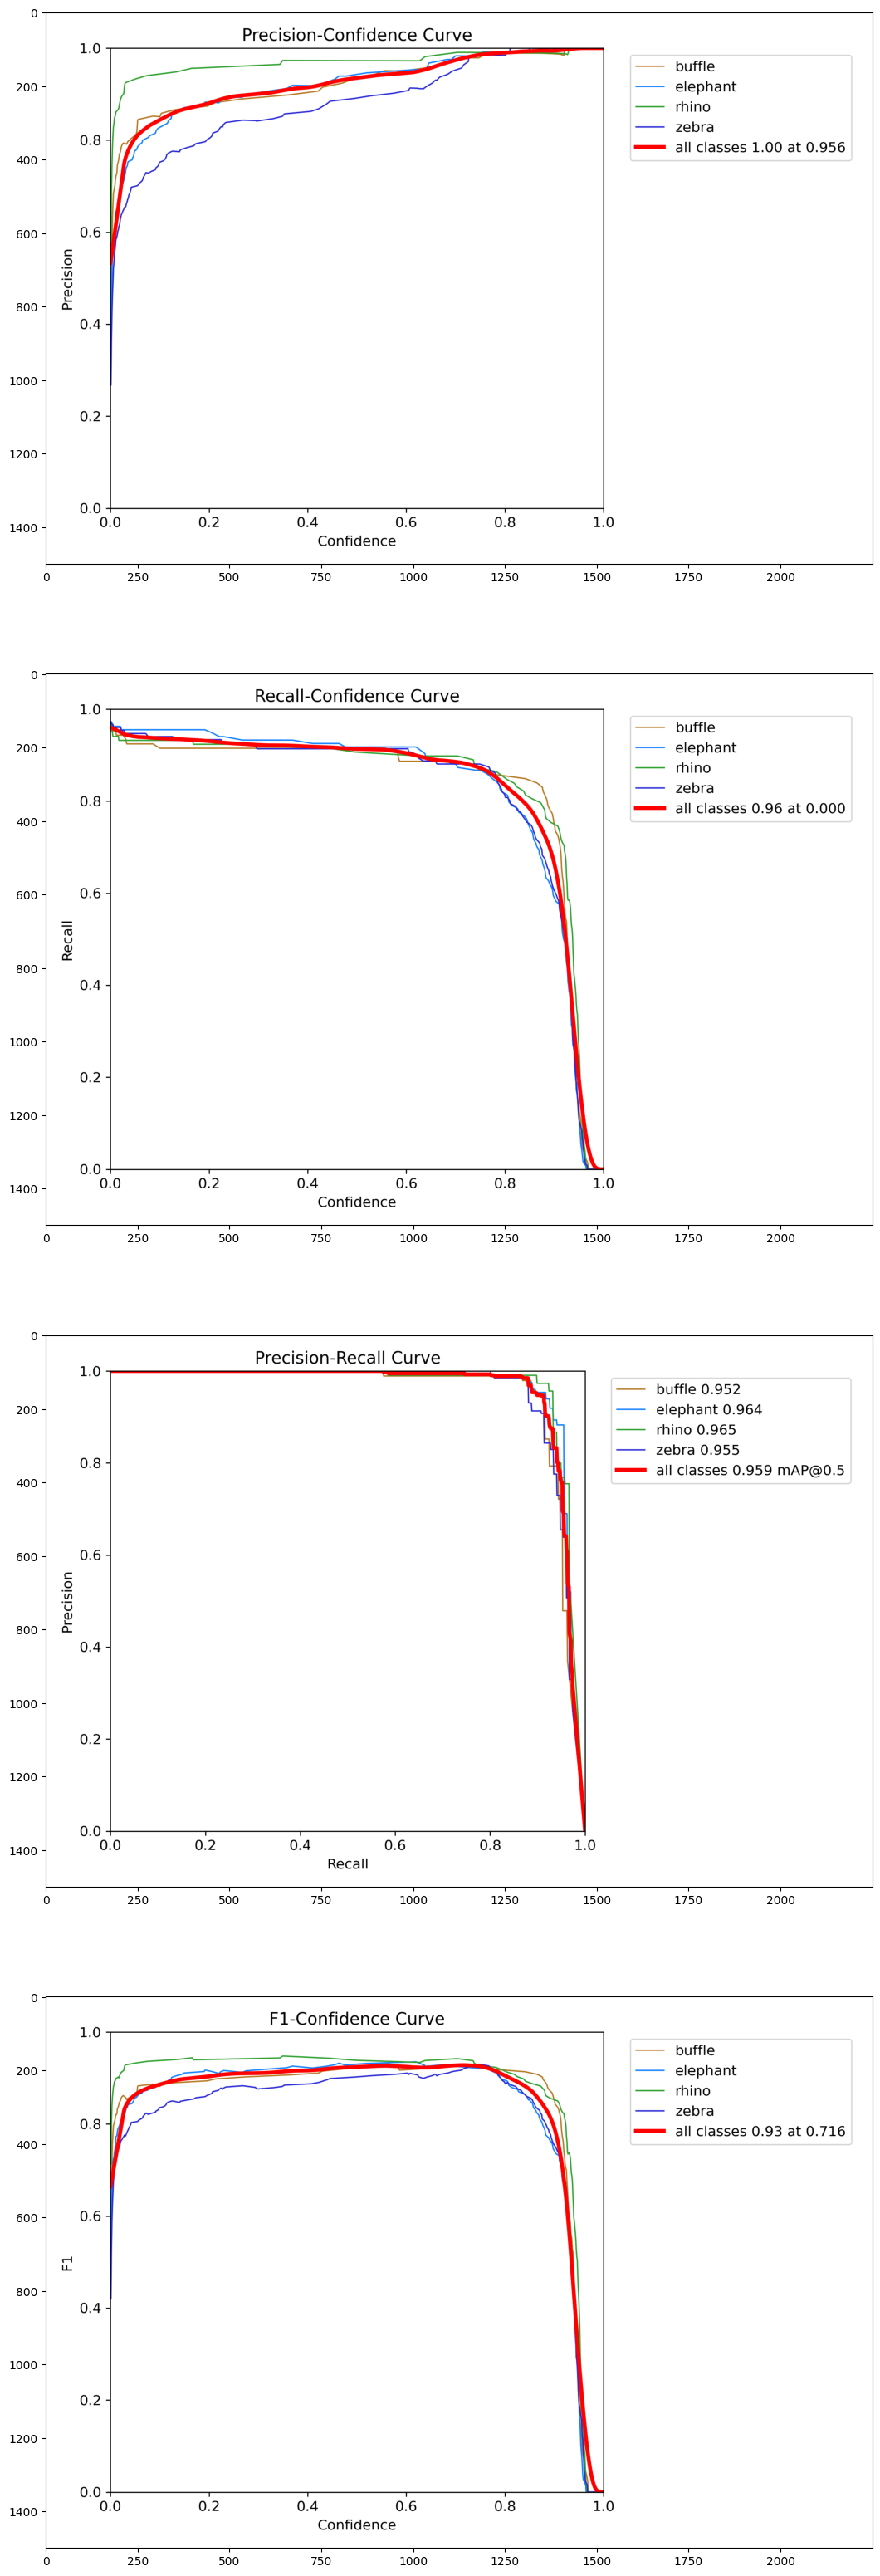

In [19]:
val_path=os.path.join(curr_path, 'runs', 'detect', 'african_wildlife_detection2') 
display_curves(val_path) 

### Analysing of the graphs

- The YOLOv8 model demonstrates robust performance across multiple metrics.
- High Precision: The model is highly accurate in its positive predictions, especially at higher confidence levels.
- High Recall: The model successfully identifies a large proportion of relevant instances, though this decreases as confidence increases.
- Balance: The model maintains a good balance between precision and recall, with a high F1 score indicating effective overall performance.
- Class Performance: The model performs consistently across different classes, with rhino detection being slightly superior in precision-recall balance.

Here I selected elephant as my favourite animal and checked how the model did the prediction on detecting elephants in the images.

In [20]:
import os
import random
import matplotlib.pyplot as plt
import cv2

# Class mapping
label_dict = {"buffle": 0, "elephant": 1, "rhino": 2, "zebra": 3}

# Display the object detection box
def plot_actual_and_predictions(imgtestpath, model, animal="elephant"):
    plt.figure(figsize=(30, 30))
    test_images = [f for f in os.listdir(imgtestpath)]
    m = random.randint(0, len(test_images) - 1)  # Selecting random image number from the test dataset
    label_id = label_dict[animal]
    
    for i in range(1, 6, 2):
        test_image = os.path.join(imgtestpath, test_images[m])
        ax = plt.subplot(3, 2, i)

        # Display actual image
        plt.imshow(cv2.cvtColor(cv2.imread(test_image), cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
        plt.xticks([])
        plt.yticks([])
        plt.title("Actual image", fontsize=40)

        # Make prediction; classes are specified for the animal we want to predict
        res = model(test_image, classes=[label_id])
        res_plotted = res[0].plot()
        ax = plt.subplot(3, 2, i + 1)

        # Display image with predictions
        plt.imshow(res_plotted)
        plt.title("Image with predictions", fontsize=40)
        plt.xticks([])
        plt.yticks([])

        m = (m + 1) % len(test_images)  # Ensure the index stays within range

    plt.show()





image 1/1 /kaggle/working/images/test/elephant_291.jpg: 640x640 1 elephant, 36.3ms
Speed: 2.1ms preprocess, 36.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/working/images/test/buffalo_300.jpg: 640x640 2 elephants, 36.2ms
Speed: 2.0ms preprocess, 36.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/working/images/test/elephant_345.jpg: 640x640 1 elephant, 36.2ms
Speed: 2.0ms preprocess, 36.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


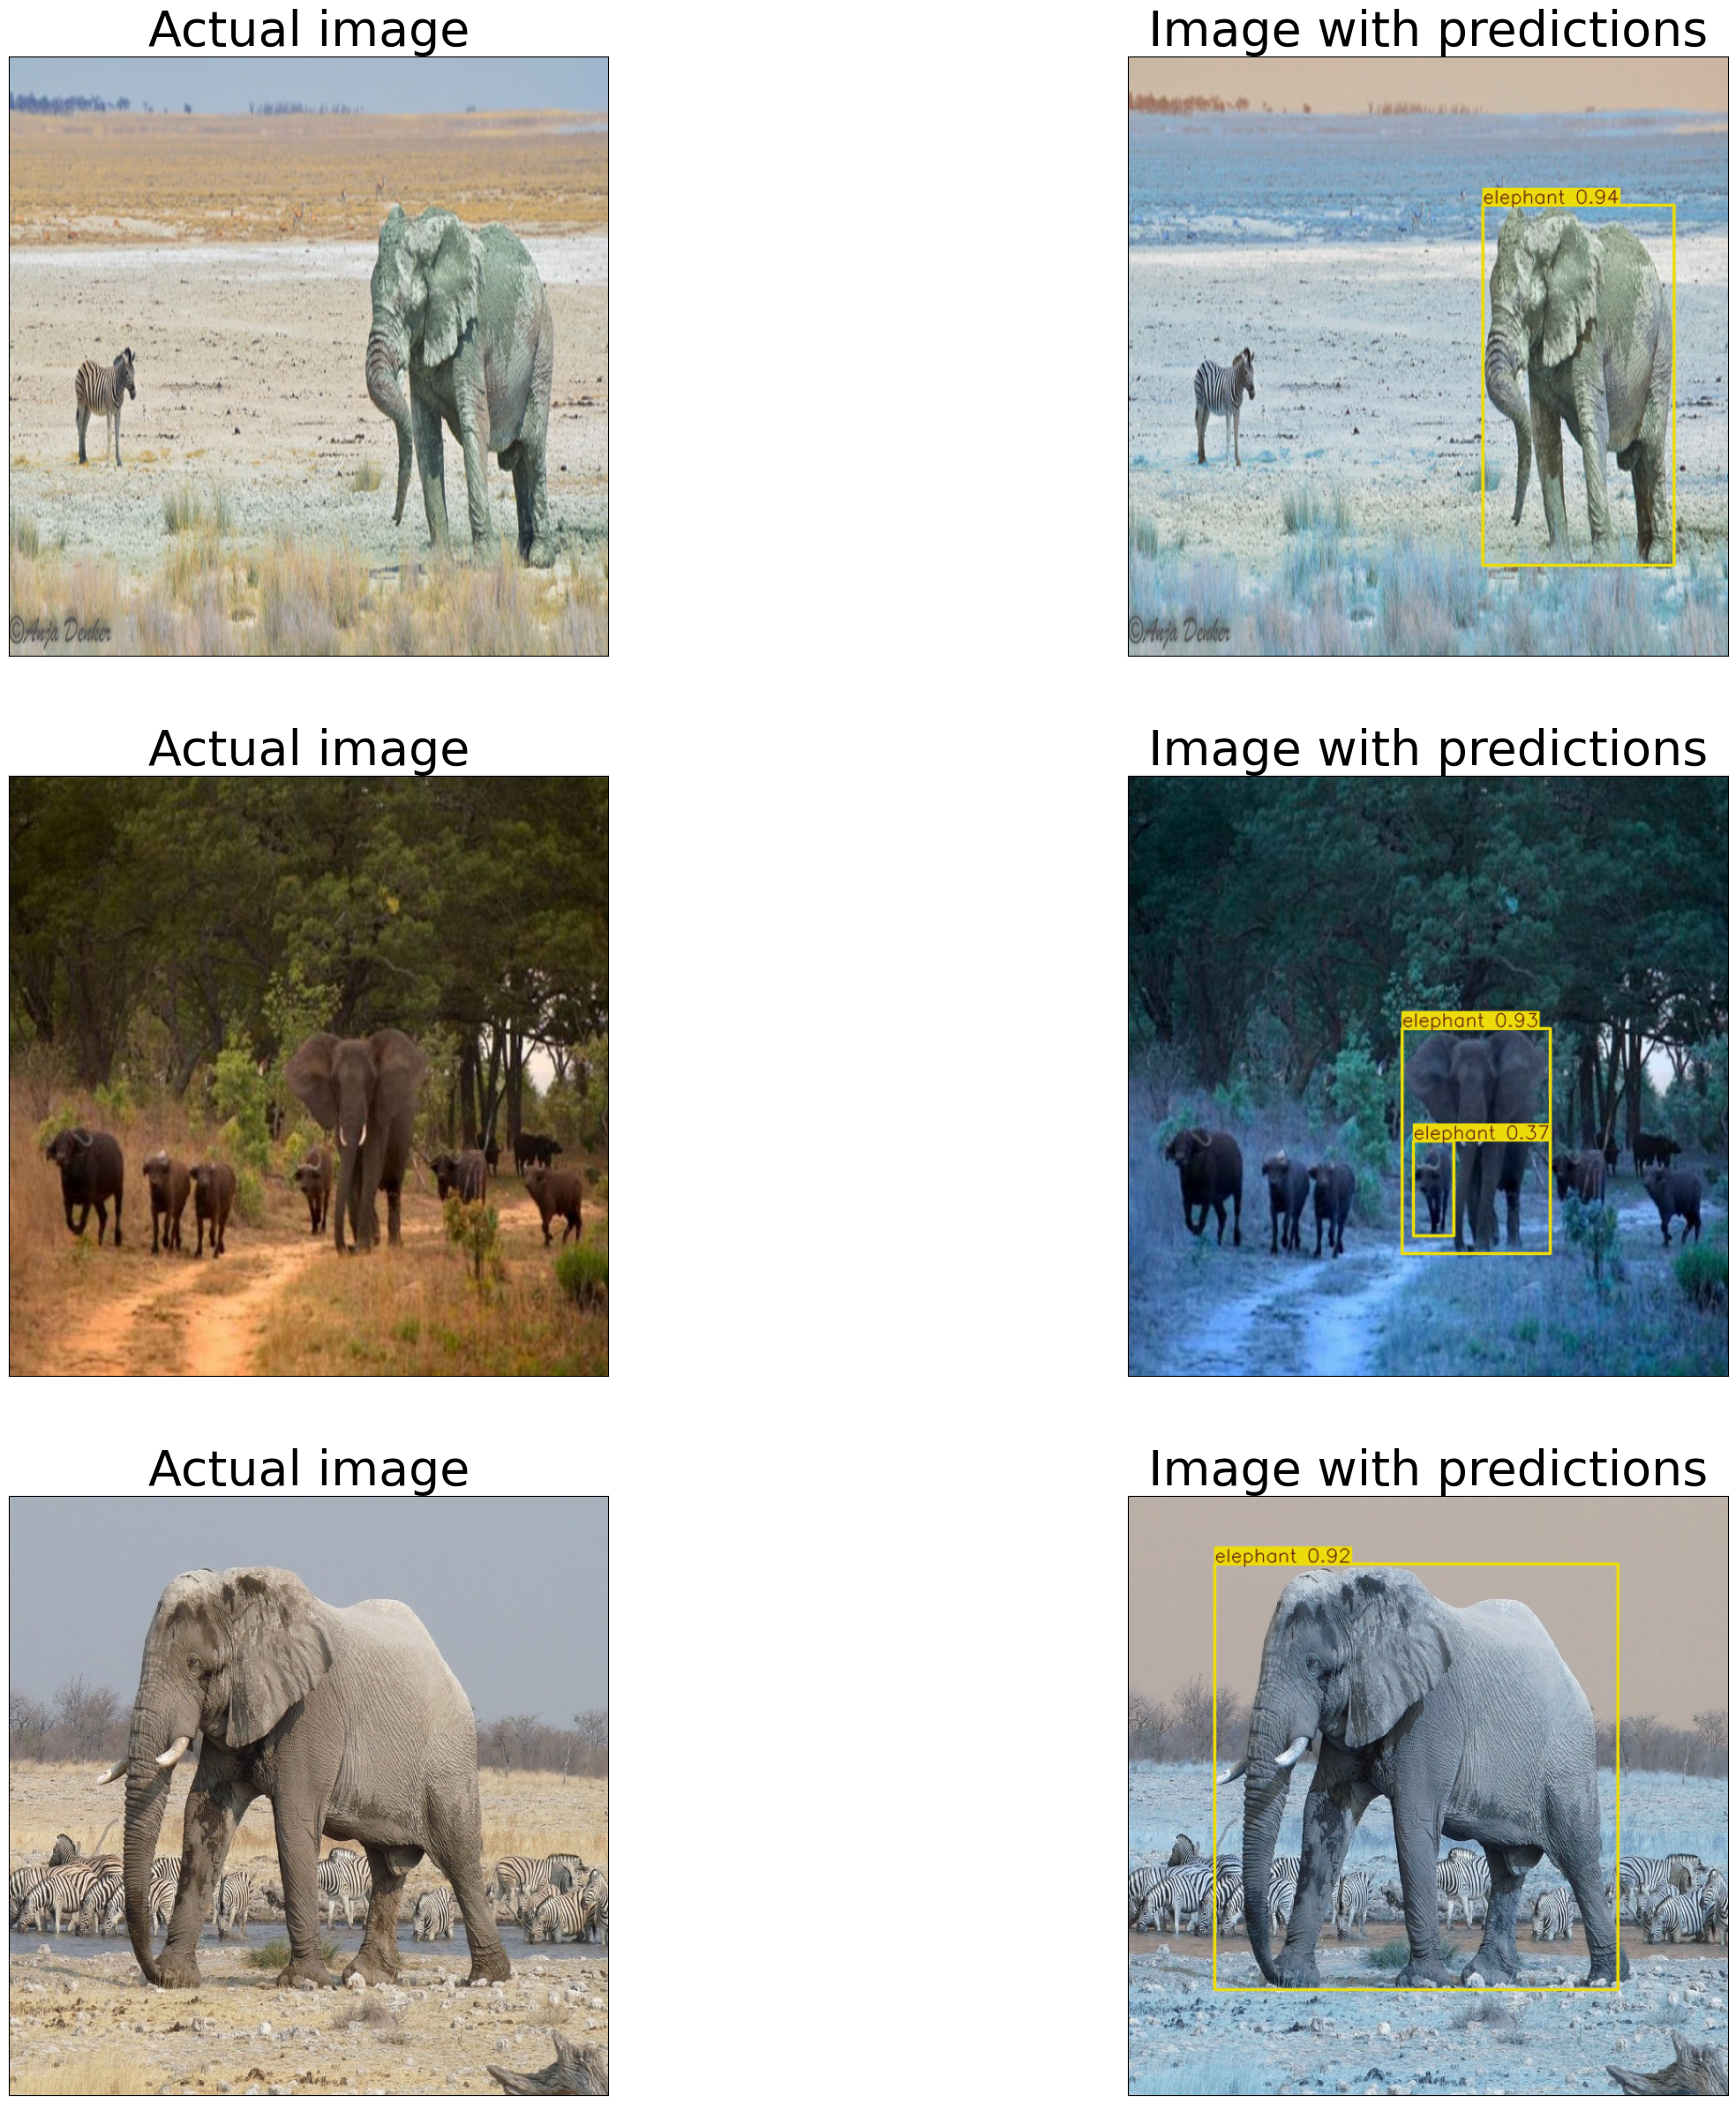

In [21]:
plot_actual_and_predictions(imgtestpath, model,animal = "elephant")

Models performance in detecting a elephant in these images with different animals is actually in a good level. But when we take the second result i can say,

Image with Predictions: The model detects two objects:
Elephant: Detected with a confidence score of 0.93.
Elephant: Detected with a confidence score of 0.37 (misidentified object).


- High Confidence Detection:

The primary elephant is detected with a high confidence score of 0.93, indicating the model's accuracy in identifying large, clear instances of the class.

- Misidentification:

The second detection, which the model labels as an elephant with a confidence score of 0.37, is actually a buffalo. This indicates a misclassification by the model.
The lower confidence score suggests the model is less certain about this detection, which aligns with the fact that it is incorrect. This misclassification may be due to similarities in the visual features of the buffalo and the smaller elephant instances, especially in a cluttered or complex environment like a forest.

### Conclusion:

The model demonstrates a high ability to detect elephants in clear conditions but struggles with distinguishing between similar animal classes in more complex settings. Addressing these challenges through additional training and model enhancements will be crucial for improving overall detection accuracy.